### Brazilian Acquirers Financial and Stock Performance vs. Macroeconomic environment 

Analyzing public traded acquirer companies, and comparing their stock and financial performance against macro indexes.

### Importings, Functions & Params

In [28]:
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt 
import numpy as np 
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator


#Data Retrieving
import yfinance as yf
from bcb import sgs 

In [29]:
#Functions
def datetime_format(date_str_col:str, date_format:str=None) -> datetime:
    """
    Streamlines datetime column conversion for data manipulation. 

    :param date_str_col: pandas.DataFrame date string-formated column
    :param date_format: date pattern to change
    """
    try:
        if (date_str_col is not None
            and ~isinstance(date_str_col, str)):
            return pd.to_datetime(date_str_col).dt.strftime(date_format)
        else: 
            raise ValueError("Wrong data type. Check your input.")
    except (TypeError, ValueError) as e: 
        raise ValueError(f"An error has ocurred: {e}")
    
def set_fig_context(ncols=1, figsize=(8,8)):
    """
    Streamlines figure context setting.

    :param ncols: number ax columns to be shown. Standard = 1
    :param figsize: figure size. Standard = (8,8)
    """
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    plt.style.use('fivethirtyeight')
    sns.set_context('paper')
    sns.set_style('whitegrid')

    plt.tight_layout()
    plt.show()
    return fig, ax

def format_numbers(num: int | float):
    """
    Format large numbers into more readable formats.

    :param num: input number [int | float]
    """
    try:
        if  7 <= len(str(num)) < 9:
            return '{:.1f}M'.format(num/1e6)
        elif len(str(num)) >= 9 :
            return '{:.1f}B'.format(num/1e9)
        else:
            raise ValueError("Number should have a length of at least 7 characters.")
    except (TypeError, ValueError) as e:
        raise ValueError(f"An error has ocurred. Check your input: {e}")

In [30]:
#Params
#Tickers
tickers = ["STNE", "PAGS", "CIEL3.SA"]

#Dates
start_date = dt.datetime.now().date() - timedelta(365*5)
base_date = start_date.strftime('%Y-%m-%d')

In [31]:
# Downloding all datasets to be used 

stne, pags, ciel3 = [],[],[]
stne_cf, pags_cf, ciel3_cf = [],[],[]
stne_financials, pags_financials, ciel3_financials = [],[],[]

for ticker in tickers:
    res = yf.download(ticker, start=start_date)
    res_ticker = yf.Ticker(ticker)
    
    if ticker == "STNE":
        stne.append(res)
        stne = pd.concat(stne, axis=0).reset_index()

        stne_financials.append(res_ticker.financials)
        stne_financials = pd.concat(stne_financials, axis=0).reset_index()
        
        stne_cf.append(res_ticker.cash_flow)
        stne_cf = pd.concat(stne_cf, axis=0).reset_index()
        
    elif ticker == "PAGS":
        pags.append(res)
        pags = pd.concat(pags, axis=0).reset_index()

        pags_financials.append(res_ticker.financials)
        pags_financials = pd.concat(pags_financials, axis=0).reset_index()

        pags_cf.append(res_ticker.cash_flow)
        pags_cf = pd.concat(pags_cf, axis=0).reset_index()

    elif ticker == "CIEL3.SA":
        ciel3.append(res)
        ciel3 = pd.concat(ciel3, axis=0).reset_index()

        ciel3_financials.append(res_ticker.financials)
        ciel3_financials = pd.concat(ciel3_financials, axis=0).reset_index()

        ciel3_cf.append(res_ticker.cash_flow)
        ciel3_cf = pd.concat(ciel3_cf, axis=0).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Stock Price and Macro Analysis

In [32]:
stne.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

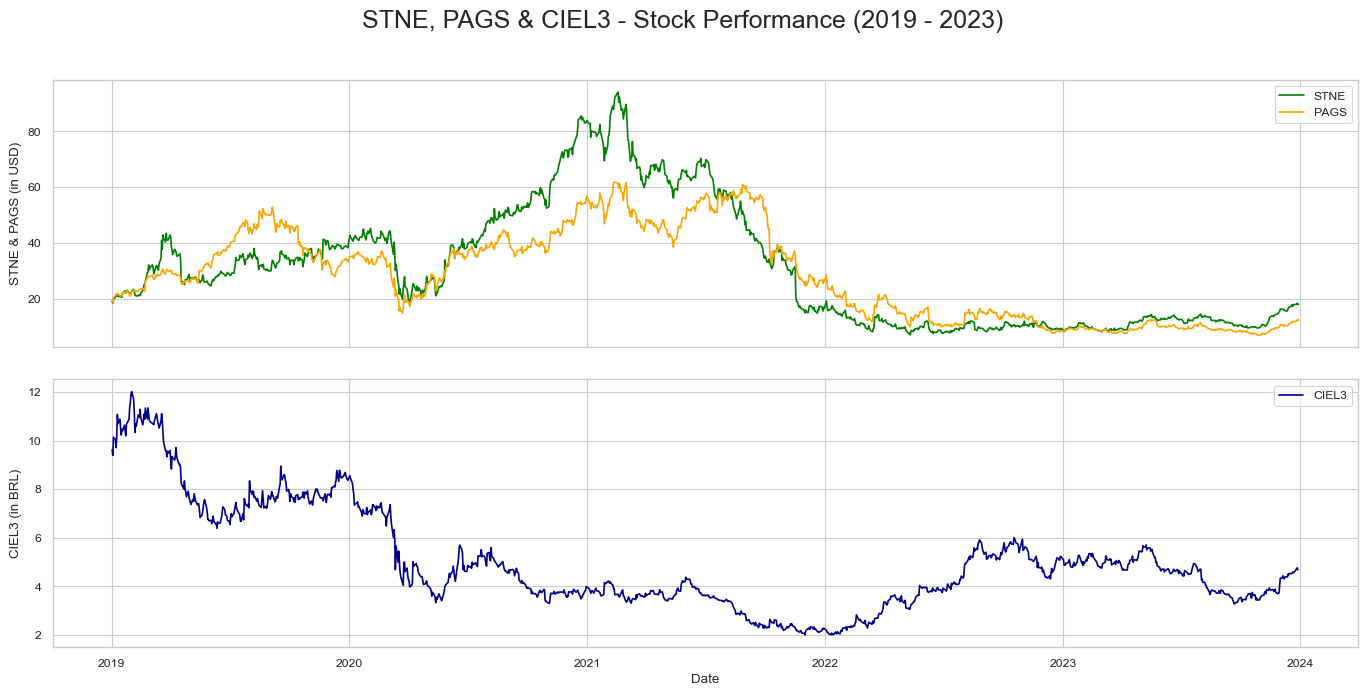

In [33]:
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(15,7), sharex=True)
sns.set_style('whitegrid')

sns.lineplot(data=stne, x='Date', y='Close', color='green', ax=ax, label='STNE')
sns.lineplot(data=pags, x='Date', y='Close', color='orange', ax=ax, label='PAGS')
ax.set_ylabel('STNE & PAGS (in USD)')

plt.suptitle("STNE, PAGS & CIEL3 - Stock Performance (2019 - 2023)", size=18)

# ax1 = ax.twinx()
sns.lineplot(data=ciel3, x='Date', y='Close', color='darkblue', ax=ax1, label='CIEL3')
ax1.set_ylabel('CIEL3 (in BRL)')

ax.legend(loc='upper right')
ax1.legend(loc='upper right')

plt.subplots_adjust(hspace=0.12)
plt.show()

In [34]:
# Getting macroeconomic data
macro_data = sgs.get({'selic':432, 'ipca':433}, start=start_date)\
                .reset_index()\
                .rename(columns=str.upper)

macro_data.head()

,DATE,SELIC,IPCA
0,2019-01-01,6.5,0.32
1,2019-01-02,6.5,NaN
2,2019-01-03,6.5,NaN
3,2019-01-04,6.5,NaN
4,2019-01-05,6.5,NaN


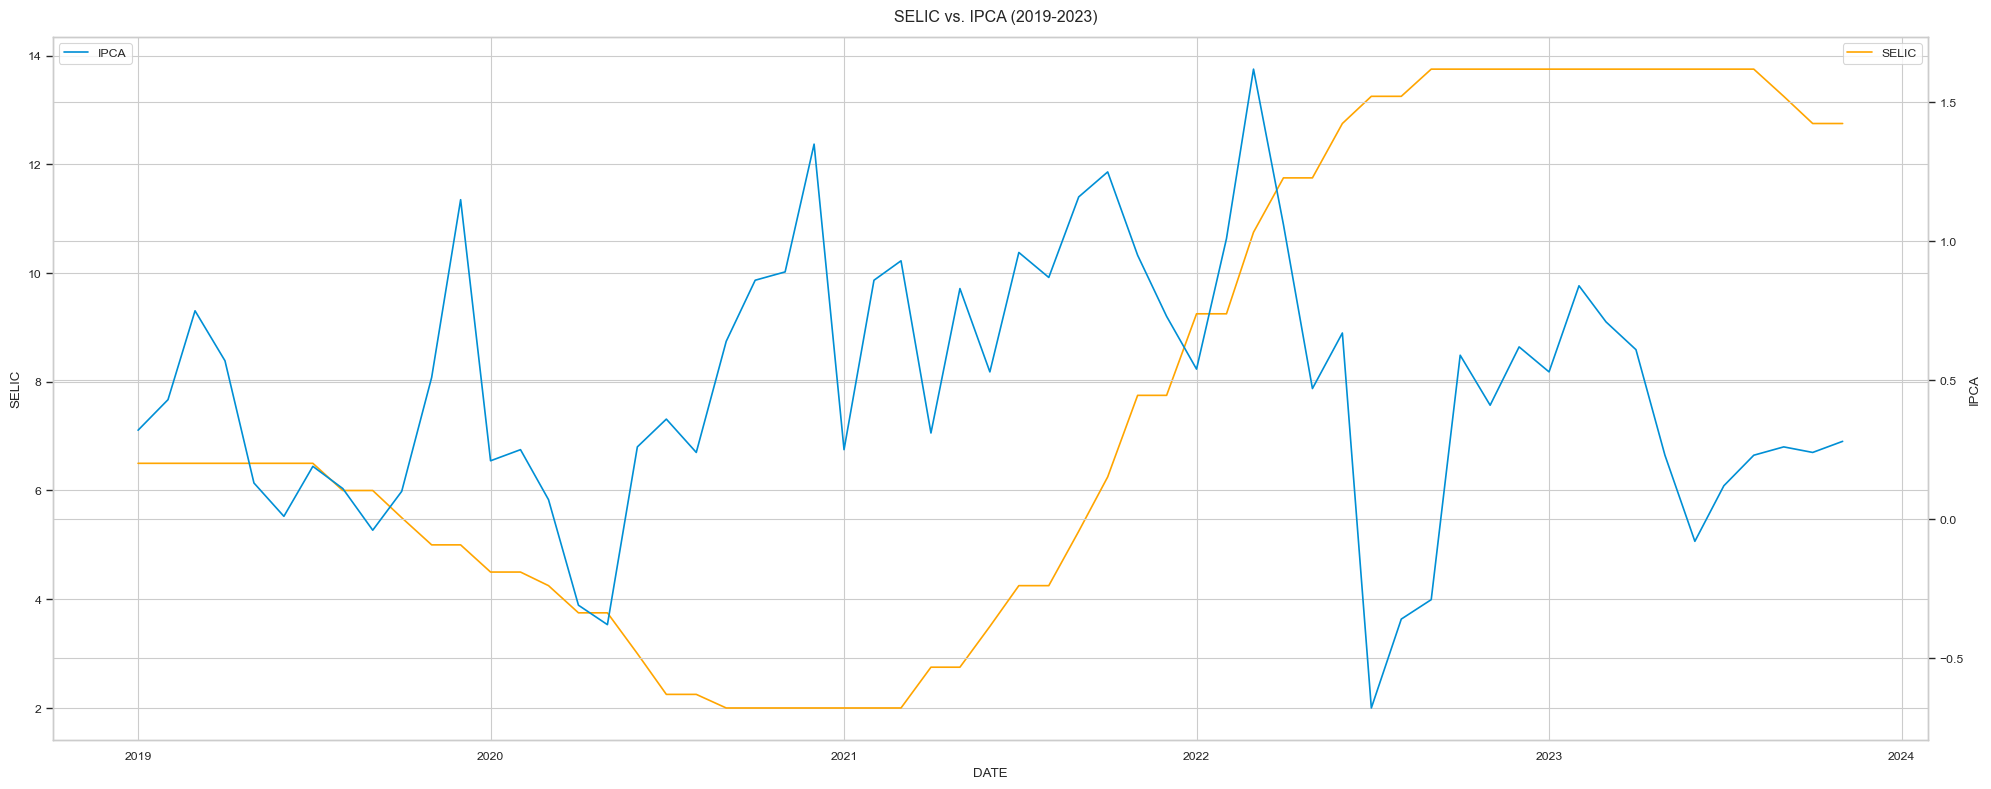

In [35]:
fig, ax = plt.subplots(figsize=(20,8))

ipca = macro_data[['DATE', 'IPCA']].dropna()
selic = macro_data[['DATE', 'SELIC']]

macro = pd.merge(ipca, selic, on='DATE', how='inner')

sns.lineplot(macro, x='DATE', y='SELIC', ax=ax, color='orange', label='SELIC')
ax1 = ax.twinx()
sns.lineplot(macro, x='DATE', y='IPCA', label='IPCA')

plt.suptitle('SELIC vs. IPCA (2019-2023)')

ax.legend(loc='upper right')
ax1.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Analyzing macro indexes correlation with stock performance 

In [36]:
### Data preparation

#Subsetting major datasets
stne_subset = stne[['Date', 'Close']].copy()
pags_subset = pags[['Date', 'Close']].copy()
ciel3_subset = ciel3[['Date', 'Close']].copy()

#Formatting date
subsets = [stne_subset, pags_subset, ciel3_subset]

for subset in subsets:
    subset['Date'] = datetime_format(subset['Date'], date_format='%Y-%b')

#Stocks unique datasets
stne_pags = pd.merge(stne_subset, pags_subset, on='Date', how='inner')
stne_pags_ciel = pd.merge(stne_pags, ciel3_subset, on='Date', how='inner')\
                    .rename(columns={
                        'Close_x':'Close_STNE',
                        'Close_y':'Close_PAGS',
                        'Close': 'Close_CIEL3'
                                    }).\
                                    sort_values(by='Date')

stne_pags_ciel = stne_pags_ciel.groupby('Date').agg('median').reset_index()
stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']] = stne_pags_ciel[['Close_STNE', 'Close_PAGS', 'Close_CIEL3']]\
                                                            .apply(lambda x: round(x, 2))

stne_pags_ciel.tail()

,Date,Close_STNE,Close_PAGS,Close_CIEL3
55,2023-Mar,9.10,8.33,5.00
56,2023-May,13.38,11.82,5.45
57,2023-Nov,13.56,8.64,3.79
58,2023-Oct,10.01,7.80,3.52
59,2023-Sep,11.38,8.65,3.55


In [37]:
# Now, macro

macro_data_subset = macro_data.rename(columns=str.capitalize)
macro_data_subset['Date'] = datetime_format(macro_data_subset['Date'], date_format='%Y-%b')

macro_data_subset = macro_data_subset.groupby('Date').agg('median').reset_index()

macro_data_subset.tail()

,Date,Selic,Ipca
55,2023-Mar,13.75,0.71
56,2023-May,13.75,0.23
57,2023-Nov,12.25,0.28
58,2023-Oct,12.75,0.24
59,2023-Sep,13.25,0.26


In [38]:
#Merging both sets together 

stocks_macro_index = pd.merge(stne_pags_ciel, macro_data_subset, on='Date', how='inner')
stocks_macro_index.tail()

,Date,Close_STNE,Close_PAGS,Close_CIEL3,Selic,Ipca
55,2023-Mar,9.10,8.33,5.00,13.75,0.71
56,2023-May,13.38,11.82,5.45,13.75,0.23
57,2023-Nov,13.56,8.64,3.79,12.25,0.28
58,2023-Oct,10.01,7.80,3.52,12.75,0.24
59,2023-Sep,11.38,8.65,3.55,13.25,0.26


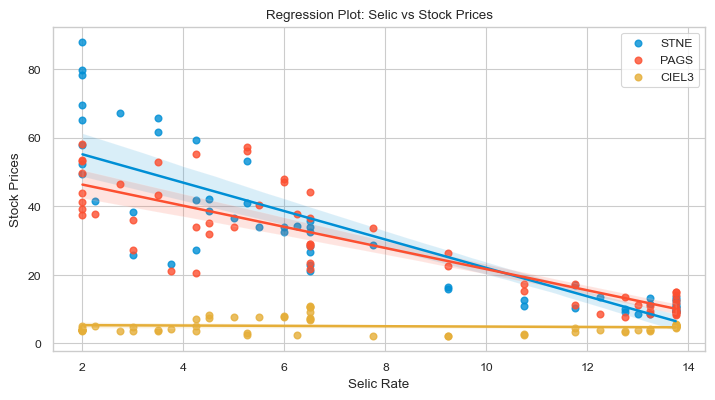

In [39]:
plt.figure(figsize=(7.5, 4))

# Plot regression plots for each stock
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_STNE', label='STNE')
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_PAGS', label='PAGS')
sns.regplot(data=stocks_macro_index, x='Selic', y='Close_CIEL3', label='CIEL3')

plt.title('Regression Plot: Selic vs Stock Prices')
plt.xlabel('Selic Rate')
plt.ylabel('Stock Prices')

plt.legend()
plt.show()

### Analyzing Correlation

For reminder, Pearson's correlation can be explain as follows:

\begin{equation}
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}
{\sqrt{\sum (x_i - \bar{x})^2 \cdot \sum (y_i - \bar{y})^2}}
\end{equation}


Text(0.5, 1.0, 'Acquirer Stocks Price and Macro Indexes Correlation')

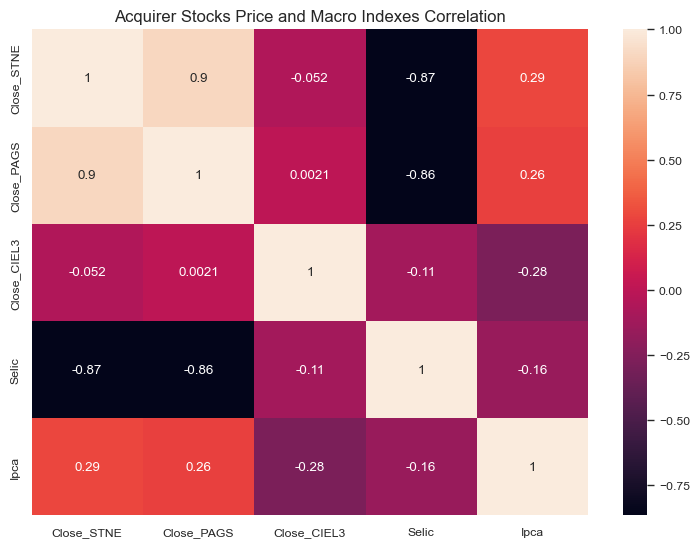

In [40]:
fig = plt.subplots(figsize=(8,6))
sns.set_context('paper')

sns.heatmap(stocks_macro_index.corr(method='pearson', numeric_only=True),
            annot=True)
plt.title("Acquirer Stocks Price and Macro Indexes Correlation", size=12)

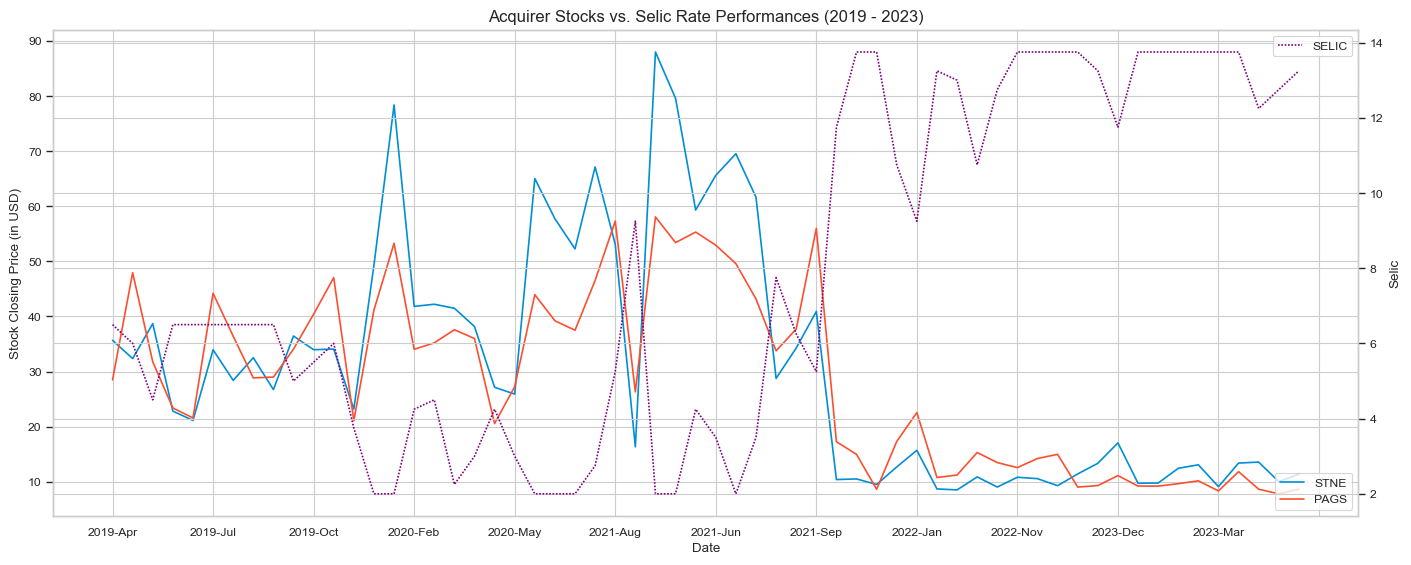

In [41]:
fig, ax = plt.subplots(figsize=(15,6))
plt.style.use('fivethirtyeight')
sns.set_context('paper')
sns.set_style('whitegrid')

stocks_only = stocks_macro_index[['Date', 'Close_STNE', 'Close_PAGS', 'Close_CIEL3']]
macro_only = stocks_macro_index[['Date', 'Ipca', 'Selic']]

sns.lineplot(data=stocks_only, x='Date', y='Close_STNE', ax=ax, label='STNE')
sns.lineplot(data=stocks_only, x='Date', y='Close_PAGS', ax=ax, label='PAGS')
ax.set_ylabel('Stock Closing Price (in USD)')
ax1 = ax.twinx()
sns.lineplot(data=macro_only, x='Date', y='Selic', ax=ax1, color='purple', label='SELIC', dashes=(1,1))

ax.legend(loc='lower right')
ax1.legend(loc='upper right')

plt.title("Acquirer Stocks vs. Selic Rate Performances (2019 - 2023)", size=12)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15, integer=True))

### Acquirer Revenue Financial Performance vs. Macro Environment

What's the macro indexes impact on Acquirer Revenue and TPV?

In [50]:
## Dataset formatting and cleaning

financial_cols_rename = {
    '2022-12-31 00:00:00': 'FY2022',
    '2021-12-31 00:00:00': 'FY2021',
    '2020-12-31 00:00:00': 'FY2020'
}

financials_datasets = [stne_financials, pags_financials, ciel3_financials, stne_cf, pags_cf, ciel3_cf]

for i, fs in list(enumerate(financials_datasets)):
    fs.rename(columns=str, inplace=True)
    fs.rename(columns=financial_cols_rename, inplace=True)

### Calculating WACC for the three companies

[*Weighted Average Cost of Capital*](https://www.investopedia.com/terms/w/wacc.asp).

The _Weighted Average Cost of Capital_ represents the average rate a company expects to pay to finance its business, considering all sources: preferred and common stocks, bonds, as well as other form of debts. It's an weighted average of the cost of equity, and the cost of debt after taxes. The weights are the proportion of each source of financing. It's represented as follows:

\begin{equation}
WACC = \frac{E}{V} \cdot Re + \frac{D}{V} \cdot Rd \cdot (1 - Tc)
\end{equation}

- $WACC$: is the Weighted Average Cost of Capital.
- $E$: is the market value of equity.
- $V$: is the total market value of equity and debt.
- $Re$: is the cost of equity.
- $D$: is the market value of debt.
- $Rd$: is the cost of debt.
- $Tc$: Tc is the corporate tax rate.

It can be calculated as follows:

```python
def wacc(cost_of_equity, market_value_of_equity, cost_of_debt, market_value_of_debt, tax_rate):
    equity_proportion = market_value_of_equity / (market_value_of_equity + market_value_of_debt)
    debt_proportion = market_value_of_debt / (market_value_of_equity + market_value_of_debt)

    wacc = equity_proportion * cost_of_equity + debt_proportion * cost_of_debt * (1 - tax_rate)
    
    return wacc
```